In [1]:
# 8.1.3 Procedures
# The procedures can be found in the canvas module. Check the following under topics:
# 8.2 Querying and Merging
# 8.3 Dataframe Operations
# 8.4 Aggregations
# 8.5 Time Series

## 8.2 Querying and Merging

### Setup

In [7]:
import pandas as pd
weather = pd.read_csv('datasets/nyc_weather_2018.csv')

weather.head()

,attributes,datatype,date,station,value
0,",,N,",PRCP,2018-01-01T00:00:00,GHCND:US1CTFR0039,0.0
1,",,N,",PRCP,2018-01-01T00:00:00,GHCND:US1NJBG0015,0.0
2,",,N,",SNOW,2018-01-01T00:00:00,GHCND:US1NJBG0015,0.0
3,",,N,",PRCP,2018-01-01T00:00:00,GHCND:US1NJBG0017,0.0
4,",,N,",SNOW,2018-01-01T00:00:00,GHCND:US1NJBG0017,0.0


### Querying DataFrames

In [9]:
snow_data = weather.query('datatype == "SNOW" and value > 0')
snow_data.head()

,attributes,datatype,date,station,value
124,",,N,",SNOW,2018-01-01T00:00:00,GHCND:US1NYWC0019,25.0
723,",,N,",SNOW,2018-01-04T00:00:00,GHCND:US1NJBG0015,229.0
726,",,N,",SNOW,2018-01-04T00:00:00,GHCND:US1NJBG0017,10.0
730,",,N,",SNOW,2018-01-04T00:00:00,GHCND:US1NJBG0018,46.0
737,",,N,",SNOW,2018-01-04T00:00:00,GHCND:US1NJES0018,10.0


In [15]:
import sqlite3
with sqlite3.connect('databases/weather.db') as connection:
    snow_data_from_db = pd.read_sql(
        'SELECT * FROM weather WHERE datatype == "SNOW" AND value > 0',
        connection
    )

snow_data.reset_index().drop(columns='index').equals(snow_data_from_db)

True

In [17]:
weather[(weather.datatype == 'SNOW') & (weather.value > 0)].equals(snow_data)

True

### Merging DataFrames

In [23]:
station_info = pd.read_csv('datasets/weather_stations.csv')
station_info.head()

,id,name,latitude,longitude,elevation
0,GHCND:US1CTFR0022,"STAMFORD 2.6 SSW, CT US",41.0641,-73.5770,36.6
1,GHCND:US1CTFR0039,"STAMFORD 4.2 S, CT US",41.0378,-73.5682,6.4
2,GHCND:US1NJBG0001,"BERGENFIELD 0.3 SW, NJ US",40.9213,-74.0020,20.1
3,GHCND:US1NJBG0002,"SADDLE BROOK TWP 0.6 E, NJ US",40.9027,-74.0834,16.8
4,GHCND:US1NJBG0003,"TENAFLY 1.3 W, NJ US",40.9147,-73.9775,21.6


In [25]:
weather.head()

,attributes,datatype,date,station,value
0,",,N,",PRCP,2018-01-01T00:00:00,GHCND:US1CTFR0039,0.0
1,",,N,",PRCP,2018-01-01T00:00:00,GHCND:US1NJBG0015,0.0
2,",,N,",SNOW,2018-01-01T00:00:00,GHCND:US1NJBG0015,0.0
3,",,N,",PRCP,2018-01-01T00:00:00,GHCND:US1NJBG0017,0.0
4,",,N,",SNOW,2018-01-01T00:00:00,GHCND:US1NJBG0017,0.0


In [27]:
station_info.id.describe()

count                   262
unique                  262
top       GHCND:US1CTFR0022
freq                      1
Name: id, dtype: object

In [29]:
weather.station.describe()

count                 80256
unique                  109
top       GHCND:USW00094789
freq                   4270
Name: station, dtype: object

In [31]:
station_info.shape[0], weather.shape[0]

(262, 80256)

In [33]:
def get_row_count(*dfs):
    return [df.shape[0] for df in dfs]
get_row_count(station_info, weather)

[262, 80256]

In [35]:
def get_info(attr, *dfs):
    return list(map(lambda x: getattr(x, attr), dfs))
get_info('shape', station_info, weather)

[(262, 5), (80256, 5)]

In [37]:
inner_join = weather.merge(station_info, left_on='station', right_on='id')
inner_join.sample(5, random_state=0)

,attributes,datatype,date,station,value,id,name,latitude,longitude,elevation
27422,",,W,",WDF5,2018-04-29T00:00:00,GHCND:USW00094741,310.0,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",40.85000,-74.06139,2.7
19317,",,W,",WSF5,2018-03-24T00:00:00,GHCND:USW00094728,8.5,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7
13778,",,W,",PGTM,2018-03-01T00:00:00,GHCND:USW00054743,2351.0,GHCND:USW00054743,"CALDWELL ESSEX CO AIRPORT, NJ US",40.87639,-74.28306,52.7
39633,",,W,",WSF2,2018-06-25T00:00:00,GHCND:USW00094789,11.2,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63860,-73.76220,3.4
51025,",,7,0700",TMAX,2018-08-19T00:00:00,GHCND:USC00280907,30.0,GHCND:USC00280907,"BOONTON 1 SE, NJ US",40.89174,-74.39635,85.3


In [39]:
weather.merge(station_info.rename(dict(id='station'), axis=1), on='station').sample(5, random_state=0)

,attributes,datatype,date,station,value,name,latitude,longitude,elevation
27422,",,W,",WDF5,2018-04-29T00:00:00,GHCND:USW00094741,310.0,"TETERBORO AIRPORT, NJ US",40.85000,-74.06139,2.7
19317,",,W,",WSF5,2018-03-24T00:00:00,GHCND:USW00094728,8.5,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7
13778,",,W,",PGTM,2018-03-01T00:00:00,GHCND:USW00054743,2351.0,"CALDWELL ESSEX CO AIRPORT, NJ US",40.87639,-74.28306,52.7
39633,",,W,",WSF2,2018-06-25T00:00:00,GHCND:USW00094789,11.2,"JFK INTERNATIONAL AIRPORT, NY US",40.63860,-73.76220,3.4
51025,",,7,0700",TMAX,2018-08-19T00:00:00,GHCND:USC00280907,30.0,"BOONTON 1 SE, NJ US",40.89174,-74.39635,85.3


In [41]:
left_join = station_info.merge(weather, left_on='id', right_on='station', how='left')
right_join = weather.merge(station_info, left_on='station', right_on='id', how='right')
right_join.tail()

,attributes,datatype,date,station,value,id,name,latitude,longitude,elevation
80404,",,W,",WDF5,2018-12-31T00:00:00,GHCND:USW00094789,130.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.6386,-73.7622,3.4
80405,",,W,",WSF2,2018-12-31T00:00:00,GHCND:USW00094789,9.8,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.6386,-73.7622,3.4
80406,",,W,",WSF5,2018-12-31T00:00:00,GHCND:USW00094789,12.5,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.6386,-73.7622,3.4
80407,",,W,",WT01,2018-12-31T00:00:00,GHCND:USW00094789,1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.6386,-73.7622,3.4
80408,",,W,",WT02,2018-12-31T00:00:00,GHCND:USW00094789,1.0,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.6386,-73.7622,3.4


In [43]:
left_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index').equals(
    right_join.sort_index(axis=1).sort_values(['date', 'station']).reset_index().drop(columns='index')
)

True

In [45]:
get_info('shape', inner_join, left_join, right_join)

[(80256, 10), (80409, 10), (80409, 10)]

In [63]:
outer_join = weather.merge(
 station_info[station_info.name.str.contains('NY')],
 left_on='station', right_on='id', how='outer', indicator=True
)
# outer_join.sample(4, random_state=0).append(outer_join[outer_join.station.isna()].head(2)) >> AttributeError: 'DataFrame' object has no attribute 'append'
pd.concat([
    outer_join.sample(4, random_state=0),
    outer_join[outer_join.station.isna()].head(2)
])

,attributes,datatype,date,station,value,id,name,latitude,longitude,elevation,_merge
17259,",,N,",SNOW,2018-07-20T00:00:00,GHCND:US1NJMS0075,0.0,NaN,NaN,NaN,NaN,NaN,left_only
76178,",,W,",AWND,2018-01-12T00:00:00,GHCND:USW00094789,7.2,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63860,-73.7622,3.4,both
73410,"T,,W,2400",PRCP,2018-03-16T00:00:00,GHCND:USW00094745,0.0,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",41.06694,-73.7075,115.5,both
74822,",,W,",PGTM,2018-08-20T00:00:00,GHCND:USW00094745,1641.0,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",41.06694,-73.7075,115.5,both
14954,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJMS0036,"PARSIPPANY TROY HILLS TWP 2.1, NJ US",40.86560,-74.3851,64.3,right_only
14955,NaN,NaN,NaN,NaN,NaN,GHCND:US1NJMS0039,"PARSIPPANY TROY HILLS TWP 1.3, NJ US",40.85330,-74.4470,94.2,right_only


In [79]:
import sqlite3
with sqlite3.connect('databases/weather.db') as connection:
    inner_join_from_db = pd.read_sql(
        'SELECT * FROM weather JOIN stations ON weather.station == stations.id',
        connection
    )
inner_join_from_db.shape == inner_join.shape

True

In [91]:
dirty_data = pd.read_csv(
    'datasets/dirty_data.csv', index_col='date'
).drop_duplicates().drop(columns='SNWD')
dirty_data.head()

,station,PRCP,SNOW,TMAX,TMIN,TOBS,WESF,inclement_weather
date,,,,,,,,
2018-01-01T00:00:00,?,0.0,0.0,5505.0,-40.0,NaN,NaN,NaN
2018-01-02T00:00:00,GHCND:USC00280907,0.0,0.0,-8.3,-16.1,-12.2,NaN,False
2018-01-03T00:00:00,GHCND:USC00280907,0.0,0.0,-4.4,-13.9,-13.3,NaN,False
2018-01-04T00:00:00,?,20.6,229.0,5505.0,-40.0,NaN,19.3,True
2018-01-05T00:00:00,?,0.3,NaN,5505.0,-40.0,NaN,NaN,NaN


In [95]:
valid_station = dirty_data.query('station != "?"').copy().drop(columns=['WESF', 'station'])
station_with_wesf = dirty_data.query('station == "?"').copy().drop(columns=['station', 'TOBS', 'TMIN', 'TMAX'])

In [97]:
valid_station.merge(
    station_with_wesf, left_index=True, right_index=True
).query('WESF > 0').head()

,PRCP_x,SNOW_x,TMAX,TMIN,TOBS,inclement_weather_x,PRCP_y,SNOW_y,WESF,inclement_weather_y
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [99]:
valid_station.merge(
    station_with_wesf, left_index=True, right_index=True, suffixes=('', '_?')
).query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [101]:
valid_station.join(station_with_wesf, rsuffix='_?').query('WESF > 0').head()

,PRCP,SNOW,TMAX,TMIN,TOBS,inclement_weather,PRCP_?,SNOW_?,WESF,inclement_weather_?
date,,,,,,,,,,
2018-01-30T00:00:00,0.0,0.0,6.7,-1.7,-0.6,False,1.5,13.0,1.8,True
2018-03-08T00:00:00,48.8,NaN,1.1,-0.6,1.1,False,28.4,NaN,28.7,NaN
2018-03-13T00:00:00,4.1,51.0,5.6,-3.9,0.0,True,3.0,13.0,3.0,True
2018-03-21T00:00:00,0.0,0.0,2.8,-2.8,0.6,False,6.6,114.0,8.6,True
2018-04-02T00:00:00,9.1,127.0,12.8,-1.1,-1.1,True,14.0,152.0,15.2,True


In [103]:
weather.set_index('station', inplace=True)
station_info.set_index('id', inplace=True)

In [105]:
weather.index.intersection(station_info.index)

Index(['GHCND:US1CTFR0039', 'GHCND:US1NJBG0015', 'GHCND:US1NJBG0017',
       'GHCND:US1NJBG0018', 'GHCND:US1NJBG0023', 'GHCND:US1NJBG0030',
       'GHCND:US1NJBG0039', 'GHCND:US1NJBG0044', 'GHCND:US1NJES0018',
       'GHCND:US1NJES0024',
       ...
       'GHCND:US1NJMS0047', 'GHCND:US1NYSF0083', 'GHCND:US1NYNY0074',
       'GHCND:US1NJPS0018', 'GHCND:US1NJBG0037', 'GHCND:USC00284987',
       'GHCND:US1NJES0031', 'GHCND:US1NJMD0086', 'GHCND:US1NJMS0097',
       'GHCND:US1NJMN0081'],
      dtype='object', length=109)

In [107]:
weather.index.difference(station_info.index)

Index([], dtype='object')

In [109]:
station_info.index.difference(weather.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1NJBG0001', 'GHCND:US1NJBG0002',
       'GHCND:US1NJBG0005', 'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008',
       'GHCND:US1NJBG0011', 'GHCND:US1NJBG0012', 'GHCND:US1NJBG0013',
       'GHCND:US1NJBG0020',
       ...
       'GHCND:USC00308322', 'GHCND:USC00308749', 'GHCND:USC00308946',
       'GHCND:USC00309117', 'GHCND:USC00309270', 'GHCND:USC00309400',
       'GHCND:USC00309466', 'GHCND:USC00309576', 'GHCND:USW00014708',
       'GHCND:USW00014786'],
      dtype='object', length=153)

In [111]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).shape[0]\
+ weather.index.difference(ny_in_name.index).shape[0]\
== weather.index.symmetric_difference(ny_in_name.index).shape[0]

True

In [113]:
weather.index.unique().union(station_info.index)

Index(['GHCND:US1CTFR0022', 'GHCND:US1CTFR0039', 'GHCND:US1NJBG0001',
       'GHCND:US1NJBG0002', 'GHCND:US1NJBG0003', 'GHCND:US1NJBG0005',
       'GHCND:US1NJBG0006', 'GHCND:US1NJBG0008', 'GHCND:US1NJBG0010',
       'GHCND:US1NJBG0011',
       ...
       'GHCND:USW00014708', 'GHCND:USW00014732', 'GHCND:USW00014734',
       'GHCND:USW00014786', 'GHCND:USW00054743', 'GHCND:USW00054787',
       'GHCND:USW00094728', 'GHCND:USW00094741', 'GHCND:USW00094745',
       'GHCND:USW00094789'],
      dtype='object', length=262)

In [115]:
ny_in_name = station_info[station_info.name.str.contains('NY')]
ny_in_name.index.difference(weather.index).union(weather.index.difference(ny_in_name.index)).equals(
    weather.index.symmetric_difference(ny_in_name.index)
)

True

## 8.3 Dataframe Operations

### setup

In [124]:
import numpy as np
import pandas as pd
weather = pd.read_csv('datasets/nyc_weather_2018.csv', parse_dates=['date'])
weather.head()

,attributes,datatype,date,station,value
0,",,N,",PRCP,2018-01-01,GHCND:US1CTFR0039,0.0
1,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0015,0.0
2,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0015,0.0
3,",,N,",PRCP,2018-01-01,GHCND:US1NJBG0017,0.0
4,",,N,",SNOW,2018-01-01,GHCND:US1NJBG0017,0.0


In [128]:
fb = pd.read_csv('datasets/fb_2018.csv', index_col='date', parse_dates=True)
fb.head()

,open,high,low,close,volume
date,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903
2018-01-03,181.88,184.78,181.3300,184.67,16886563
2018-01-04,184.90,186.21,184.0996,184.33,13880896
2018-01-05,185.59,186.90,184.9300,186.85,13574535
2018-01-08,187.20,188.90,186.3300,188.28,17994726


### Arithmetic and statistics

In [131]:
fb.assign(
 abs_z_score_volume=lambda x: x.volume.sub(x.volume.mean()).div(x.volume.std()).abs()
).query('abs_z_score_volume > 3')

,open,high,low,close,volume,abs_z_score_volume
date,,,,,,
2018-03-19,177.01,177.17,170.06,172.56,88140060,3.145078
2018-03-20,167.47,170.20,161.95,168.15,129851768,5.315169
2018-03-21,164.80,173.40,163.30,169.39,106598834,4.105413
2018-03-26,160.82,161.10,149.02,160.06,126116634,5.120845
2018-07-26,174.89,180.13,173.75,176.26,169803668,7.393705


In [133]:
fb.assign(
 volume_pct_change=fb.volume.pct_change(),
 pct_change_rank=lambda x: x.volume_pct_change.abs().rank(
 ascending=False
 )
).nsmallest(5, 'pct_change_rank')

,open,high,low,close,volume,volume_pct_change,pct_change_rank
date,,,,,,,
2018-01-12,178.06,181.48,177.40,179.37,77551299,7.087876,1.0
2018-03-19,177.01,177.17,170.06,172.56,88140060,2.611789,2.0
2018-07-26,174.89,180.13,173.75,176.26,169803668,1.628841,3.0
2018-09-21,166.64,167.25,162.81,162.93,45994800,1.428956,4.0
2018-03-26,160.82,161.10,149.02,160.06,126116634,1.352496,5.0


In [137]:
fb['2018-01-11':'2018-01-12']

,open,high,low,close,volume
date,,,,,
2018-01-11,188.40,188.40,187.38,187.77,9588587
2018-01-12,178.06,181.48,177.40,179.37,77551299


In [139]:
(fb > 215).any()

open       True
high       True
low       False
close      True
volume     True
dtype: bool

In [141]:
(fb > 215).all()

open      False
high      False
low       False
close     False
volume     True
dtype: bool

### Binning and thresholds

In [146]:
(fb.volume.value_counts() > 1).sum()

0

In [148]:
volume_binned = pd.cut(fb.volume, bins=3, labels=['low', 'med', 'high'])
volume_binned.value_counts()

volume
low     240
med       8
high      3
Name: count, dtype: int64

In [150]:
fb[volume_binned == 'high'].sort_values(
 'volume', ascending=False
)

,open,high,low,close,volume
date,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668
2018-03-20,167.47,170.20,161.95,168.15,129851768
2018-03-26,160.82,161.10,149.02,160.06,126116634


In [152]:
fb['2018-07-25':'2018-07-26']

,open,high,low,close,volume
date,,,,,
2018-07-25,215.715,218.62,214.27,217.50,64592585
2018-07-26,174.890,180.13,173.75,176.26,169803668


In [154]:
fb['2018-03-16':'2018-03-20']

,open,high,low,close,volume
date,,,,,
2018-03-16,184.49,185.33,183.41,185.09,24403438
2018-03-19,177.01,177.17,170.06,172.56,88140060
2018-03-20,167.47,170.20,161.95,168.15,129851768


In [156]:
import matplotlib.pyplot as plt

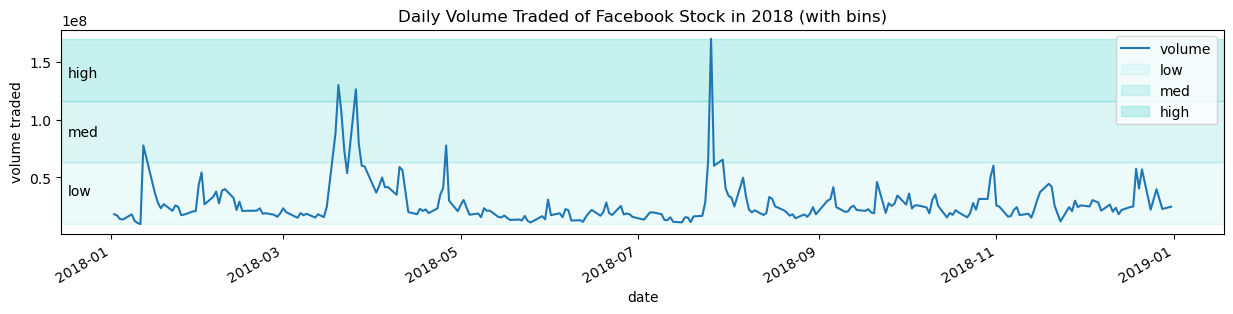

In [158]:
fb.plot(y='volume', figsize=(15, 3), title='Daily Volume Traded of Facebook Stock in 2018 (with bins)')
for bin_name, alpha, bounds in zip(
 ['low', 'med', 'high'], [0.1, 0.2, 0.3], pd.cut(fb.volume, bins=3).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()


In [160]:
volume_qbinned = pd.qcut(fb.volume, q=4, labels=['q1', 'q2', 'q3', 'q4'])
volume_qbinned.value_counts()

volume
q1    63
q2    63
q4    63
q3    62
Name: count, dtype: int64

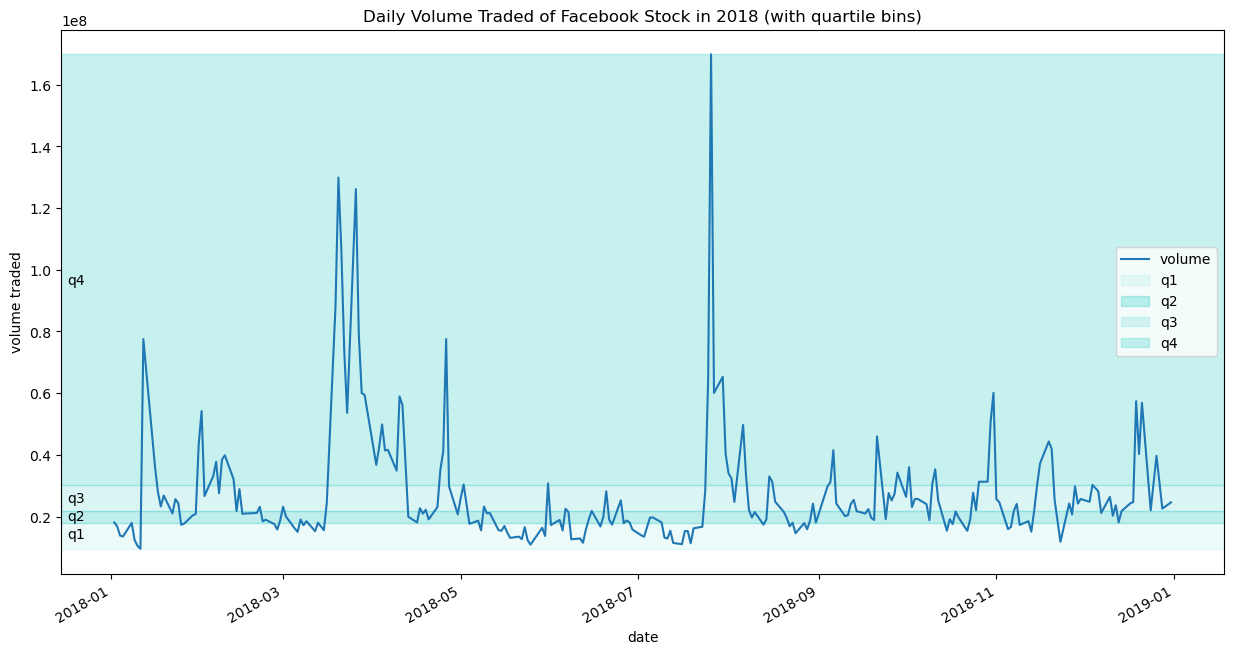

In [162]:
fb.plot(y='volume', figsize=(15, 8), title='Daily Volume Traded of Facebook Stock in 2018 (with quartile bins)')
for bin_name, alpha, bounds in zip(
 ['q1', 'q2', 'q3', 'q4'], [0.1, 0.35, 0.2, 0.3], pd.qcut(fb.volume, q=4).unique().categories.values
):
 plt.axhspan(bounds.left, bounds.right, alpha=alpha, label=bin_name, color='mediumturquoise')
 plt.annotate(bin_name, xy=('2017-12-17', (bounds.left + bounds.right)/2.1))

plt.ylabel('volume traded')
plt.legend()
plt.show()

In [164]:
central_park_weather = weather.query(
 'station == "GHCND:USW00094728"'
).pivot(index='date', columns='datatype', values='value')

In [166]:
central_park_weather.SNOW.clip(0, 1).value_counts()

SNOW
0.0    354
1.0     11
Name: count, dtype: int64

In [168]:
oct_weather_z_scores = central_park_weather.loc[
 '2018-10', ['TMIN', 'TMAX', 'PRCP']
             ].apply(lambda x: x.sub(x.mean()).div(x.std()))
oct_weather_z_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
datatype,,,,,,,,
TMIN,31.0,-1.790682e-16,1.0,-1.339112,-0.751019,-0.474269,1.065152,1.843511
TMAX,31.0,1.951844e-16,1.0,-1.305582,-0.870013,-0.138258,1.011643,1.604016
PRCP,31.0,1.038596e-16,1.0,-0.394438,-0.394438,-0.394438,-0.240253,3.936167


In [170]:
oct_weather_z_scores.query('PRCP > 3')

datatype,TMIN,TMAX,PRCP
date,,,
2018-10-27,-0.751019,-1.201045,3.936167


In [172]:
central_park_weather.loc['2018-10', 'PRCP'].describe()

count    31.000000
mean      2.941935
std       7.458542
min       0.000000
25%       0.000000
50%       0.000000
75%       1.150000
max      32.300000
Name: PRCP, dtype: float64

In [174]:
import numpy as np
fb.apply(
 lambda x: np.vectorize(lambda y: len(str(np.ceil(y))))(x)
).astype('int64').equals(
 fb.applymap(lambda x: len(str(np.ceil(x))))
)

C:\Users\uSerr\AppData\Local\Temp\ipykernel_8076\1926914613.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fb.applymap(lambda x: len(str(np.ceil(x))))


True

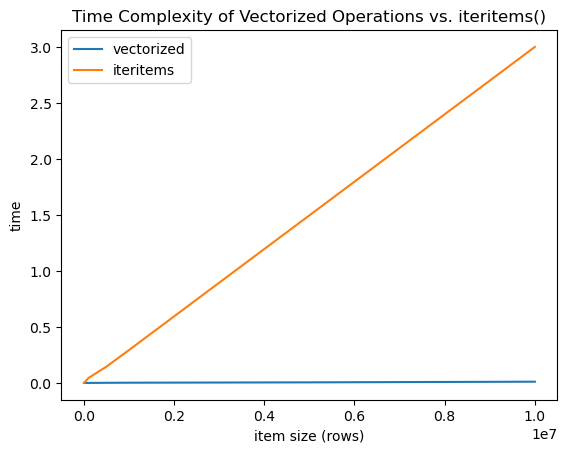

In [182]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)
vectorized_results = {}
iteritems_results = {}

for size in [10, 100, 1000, 10000, 100000, 500000, 1000000, 5000000, 10000000]:
    test = pd.Series(np.random.uniform(size=size))
    
    start = time.time()
    x = test + 10
    end = time.time()
    vectorized_results[size] = end - start
    
    start = time.time()
    x = []
    for i, v in test.items():
        x.append(v + 10)
    x = pd.Series(x)
    end = time.time()
    iteritems_results[size] = end - start
pd.DataFrame(
    [pd.Series(vectorized_results, name='vectorized'), pd.Series(iteritems_results, name='iteritems')]
).T.plot(title='Time Complexity of Vectorized Operations vs. iteritems()')
plt.xlabel('item size (rows)')
plt.ylabel('time')
plt.show()

### Window Calculations

In [191]:
central_park_weather.loc['2018-10'].assign(
         rolling_PRCP=lambda x: x.PRCP.rolling('3D').sum()
)[['PRCP', 'rolling_PRCP']].head(7).T

date,2018-10-01,2018-10-02,2018-10-03,2018-10-04,2018-10-05,2018-10-06,2018-10-07
datatype,,,,,,,
PRCP,0.0,17.5,0.0,1.0,0.0,0.0,0.0
rolling_PRCP,0.0,17.5,17.5,18.5,1.0,1.0,0.0


In [193]:
central_park_weather.loc['2018-10'].rolling('3D').mean().head(7).iloc[:,:6]

datatype,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
date,,,,,,
2018-10-01,0.900000,0.000000,0.0,0.0,24.400000,17.200000
2018-10-02,0.900000,8.750000,0.0,0.0,24.700000,17.750000
2018-10-03,0.966667,5.833333,0.0,0.0,24.233333,17.566667
2018-10-04,0.800000,6.166667,0.0,0.0,24.233333,17.200000
2018-10-05,1.033333,0.333333,0.0,0.0,23.133333,16.300000
2018-10-06,0.833333,0.333333,0.0,0.0,22.033333,16.300000
2018-10-07,1.066667,0.000000,0.0,0.0,22.600000,17.400000


In [195]:
central_park_weather['2018-10-01':'2018-10-07'].rolling('3D').agg(
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'}
).join( # join with original data for comparison
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_rolling'
).sort_index(axis=1) # sort columns so rolling calcs are next to originals

datatype,AWND,AWND_rolling,PRCP,PRCP_rolling,TMAX,TMAX_rolling,TMIN,TMIN_rolling
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.800000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,1.033333,0.0,1.0,21.7,24.4,15.6,15.6
2018-10-06,0.5,0.833333,0.0,1.0,20.0,24.4,17.2,15.6
2018-10-07,1.1,1.066667,0.0,0.0,26.1,26.1,19.4,15.6


In [197]:
central_park_weather.PRCP.expanding().sum().equals(central_park_weather.PRCP.cumsum())

False

In [199]:
central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
 {'TMAX': np.max, 'TMIN': np.min, 'AWND': np.mean, 'PRCP': np.sum}
).join(
 central_park_weather[['TMAX', 'TMIN', 'AWND', 'PRCP']],
 lsuffix='_expanding'
).sort_index(axis=1)

C:\Users\uSerr\AppData\Local\Temp\ipykernel_8076\3438569374.py:1: FutureWarning: The provided callable <function max at 0x0000026C3A5D6020> is currently using Expanding.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
C:\Users\uSerr\AppData\Local\Temp\ipykernel_8076\3438569374.py:1: FutureWarning: The provided callable <function min at 0x0000026C3A5D6160> is currently using Expanding.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  central_park_weather['2018-10-01':'2018-10-07'].expanding().agg(
C:\Users\uSerr\AppData\Local\Temp\ipykernel_8076\3438569374.py:1: FutureWarning: The provided callable <function mean at 0x0000026C3A5D6A20> is currently using Expanding.mean. In a future version of pandas, the provided callable will be used directly. To

datatype,AWND,AWND_expanding,PRCP,PRCP_expanding,TMAX,TMAX_expanding,TMIN,TMIN_expanding
date,,,,,,,,
2018-10-01,0.9,0.900000,0.0,0.0,24.4,24.4,17.2,17.2
2018-10-02,0.9,0.900000,17.5,17.5,25.0,25.0,18.3,17.2
2018-10-03,1.1,0.966667,0.0,17.5,23.3,25.0,17.2,17.2
2018-10-04,0.4,0.825000,1.0,18.5,24.4,25.0,16.1,16.1
2018-10-05,1.6,0.980000,0.0,18.5,21.7,25.0,15.6,15.6
2018-10-06,0.5,0.900000,0.0,18.5,20.0,25.0,17.2,15.6
2018-10-07,1.1,0.928571,0.0,18.5,26.1,26.1,19.4,15.6


In [201]:
fb.assign(
 close_ewma=lambda x: x.close.ewm(span=5).mean()
).tail(10)[['close', 'close_ewma']]

,close,close_ewma
date,,
2018-12-17,140.19,142.235433
2018-12-18,143.66,142.710289
2018-12-19,133.24,139.553526
2018-12-20,133.40,137.502350
2018-12-21,124.95,133.318234
2018-12-24,124.06,130.232156
2018-12-26,134.18,131.548104
2018-12-27,134.52,132.538736
2018-12-28,133.20,132.759157


### Pipes

In [228]:
def get_info(df): # added loc[], keeps returning a key error without it.
 return '%d rows and %d columns and max closing z-score was %d' % (*df.shape, df.close.max())
fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()).pipe(get_info)\
 == get_info(fb.loc['2018-Q1'].apply(lambda x: (x - x.mean())/x.std()))

True

In [230]:
pd.DataFrame.rolling(fb, '20D').mean().equals(fb.rolling('20D').mean())

True

In [4]:
from window_calc import window_calc
window_calc??

ModuleNotFoundError: No module named 'window_calc'

In [6]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

NameError: name 'window_calc' is not defined

In [9]:
window_calc(fb, pd.DataFrame.expanding, np.median).head()

NameError: name 'window_calc' is not defined

In [11]:
window_calc(fb, pd.DataFrame.ewm, 'mean', span=3).head()

NameError: name 'window_calc' is not defined

In [13]:
window_calc(
 central_park_weather['2018-10'],
 pd.DataFrame.rolling,
 {'TMAX': 'max', 'TMIN': 'min', 'AWND': 'mean', 'PRCP': 'sum'},
 '3D'
).head()

NameError: name 'window_calc' is not defined

## 8.4 Aggregations with pandas and numpy

In [17]:
### Setup

In [23]:
import numpy as np
import pandas as pd
weather = pd.read_csv('datasets/weather_by_station.csv', index_col='date', parse_dates=True)
weather.head()

,datatype,station,value,station_name
date,,,,
2018-01-01,PRCP,GHCND:US1CTFR0039,0.0,"STAMFORD 4.2 S, CT US"
2018-01-01,PRCP,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0015,0.0,"NORTH ARLINGTON 0.7 WNW, NJ US"
2018-01-01,PRCP,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"
2018-01-01,SNOW,GHCND:US1NJBG0017,0.0,"GLEN ROCK 0.7 SSE, NJ US"


In [28]:
fb = pd.read_csv('datasets/fb_2018.csv', index_col='date', parse_dates=True).assign(
 trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.5500,181.42,18151903,low
2018-01-03,181.88,184.78,181.3300,184.67,16886563,low
2018-01-04,184.90,186.21,184.0996,184.33,13880896,low
2018-01-05,185.59,186.90,184.9300,186.85,13574535,low
2018-01-08,187.20,188.90,186.3300,188.28,17994726,low


In [32]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [34]:
fb.agg({
 'open': np.mean,
 'high': np.max,
 'low': np.min,
 'close': np.mean,
 'volume': np.sum
})


C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\520208644.py:1: FutureWarning: The provided callable <function mean at 0x00000229A2279BC0> is currently using Series.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  fb.agg({
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\520208644.py:1: FutureWarning: The provided callable <function max at 0x00000229A22791C0> is currently using Series.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  fb.agg({
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\520208644.py:1: FutureWarning: The provided callable <function min at 0x00000229A2279300> is currently using Series.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  fb.agg({
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\52020

open            171.45
high            218.62
low             123.02
close           171.51
volume   6949682394.00
dtype: float64

In [37]:
weather.query(
 'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].sum()

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [39]:
weather.query(
 'station == "GHCND:USW00094728"'
).pivot(columns='datatype', values='value')[['SNOW', 'PRCP']].agg('sum')

datatype
SNOW   1007.00
PRCP   1665.30
dtype: float64

In [44]:
fb.agg({
 'open': 'mean',
 'high': ['min', 'max'],
 'low': ['min', 'max'],
'close': 'mean'
})

,open,high,low,close
mean,171.45,NaN,NaN,171.51
min,NaN,129.74,123.02,NaN
max,NaN,218.62,214.27,NaN


### Using groupby()

In [47]:
fb.groupby('trading_volume').mean()

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\46027550.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb.groupby('trading_volume').mean()


,open,high,low,close,volume
trading_volume,,,,,
low,171.36,173.46,169.31,171.43,24547207.71
med,175.82,179.42,172.11,175.14,79072559.12
high,167.73,170.48,161.57,168.16,141924023.33


In [49]:
fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\3607524933.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb.groupby('trading_volume')['close'].agg(['min', 'max', 'mean'])


,min,max,mean
trading_volume,,,
low,124.06,214.67,171.43
med,152.22,217.50,175.14
high,160.06,176.26,168.16


In [51]:
fb_agg = fb.groupby('trading_volume').agg({
 'open': 'mean',
 'high': ['min', 'max'],
 'low': ['min', 'max'],
 'close': 'mean'
})
fb_agg

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\3643718693.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fb_agg = fb.groupby('trading_volume').agg({


open   high           low         close
                 mean    min    max    min    max   mean
trading_volume                                          
low            171.36 129.74 216.20 123.02 212.60 171.43
med            175.82 162.85 218.62 150.75 214.27 175.14
high           167.73 161.10 180.13 149.02 173.75 168.16

In [53]:
fb_agg.columns

MultiIndex([( 'open', 'mean'),
            ( 'high',  'min'),
            ( 'high',  'max'),
            (  'low',  'min'),
            (  'low',  'max'),
            ('close', 'mean')],
           )

In [55]:
fb_agg.columns = ['_'.join(col_agg) for col_agg in fb_agg.columns]
fb_agg.head()


,open_mean,high_min,high_max,low_min,low_max,close_mean
trading_volume,,,,,,
low,171.36,129.74,216.20,123.02,212.60,171.43
med,175.82,162.85,218.62,150.75,214.27,175.14
high,167.73,161.10,180.13,149.02,173.75,168.16


In [107]:
weather.loc['2018-10'].query('datatype == "PRCP"').assign(
    value=lambda df: pd.to_numeric(df['value'], errors='coerce')
).groupby(
    pd.Grouper(freq='D')
)['value'].mean().head()

date
2018-10-01    0.01
2018-10-02    2.23
2018-10-03   19.69
2018-10-04    0.32
2018-10-05    0.97
Freq: D, Name: value, dtype: float64

In [82]:
weather.query('datatype == "PRCP"').groupby(
 ['station_name', pd.Grouper(freq='Q')]
).sum().unstack().sample(5, random_state=1)

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\24788615.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  ['station_name', pd.Grouper(freq='Q')]


datatype  \
date                                                                2018-03-31   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US      PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCP   

                                                                                \
date                                                                2018-06-30   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US     PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   

                                                                                \
date                                                                2018-09-30   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US     PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   

                                                                                \
date                                                                2018-12-31   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STATEN ISLAND 1.4 SE, NY US  PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
SYOSSET 2.0 SSW, NY US       PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
STAMFORD 4.2 S, CT US        PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   
WAYNE TWP 0.8 SSW, NJ US     PRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPRCPPR...   

                                                                       station  \
date                                                                2018-03-31   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       GHCND:US1NYNS0037GHCND:US1NYNS0037GHCND:US1NYN...   
STATEN ISLAND 1.4 SE, NY US  GHCND:US1NYRC0002GHCND:US1NYRC0002GHCND:US1NYR...   
SYOSSET 2.0 SSW, NY US       GHCND:US1NYNS0036GHCND:US1NYNS0036GHCND:US1NYN...   
STAMFORD 4.2 S, CT US        GHCND:US1CTFR0039GHCND:US1CTFR0039GHCND:US1CTF...   
WAYNE TWP 0.8 SSW, NJ US     GHCND:US1NJPS0015GHCND:US1NJPS0015GHCND:US1NJP...   

                                                                                \
date                                                                2018-06-30   
station_name                                                                     
WANTAGH 1.1 NNE, NY US       GHCND:US1NYNS0037GHCND:US1NYNS0037GHCND:US1NYN...   
STATEN ISLAND 1.4 SE, NY US  GHCND:US1NYRC0002GHCND:US1NYRC0002GHCND:US1NYR...   
SYOSSET 2.0 SSW, NY US       GHCND:US1NYNS0036GHCND:US1NYNS0036GHCND:US1NYN...   
STAMFORD 4.2 S, CT US        GHCND:US1CTFR0039GHCND:US1CTFR0039GHCND:US1CTF...   
WAYNE TWP 0.8 SSW, NJ US     GHCND:US1NJPS0015GHCND:US1NJPS0015GHCND:US1NJP...   

                                                                                \
date                                          

In [86]:
weather.groupby('station').filter( # station IDs with NY in them
 lambda x: 'NY' in x.name
).query('datatype == "SNOW"').groupby('station_name').sum().squeeze() # aggregate and make a series (squeeze)

,datatype,station,value
station_name,,,
"ALBERTSON 0.2 SSE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYNS0042GHCND:US1NYNS0042GHCND:US1NYN...,1087.00
"AMITYVILLE 0.1 WSW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYSF0089GHCND:US1NYSF0089GHCND:US1NYS...,434.00
"AMITYVILLE 0.6 NNE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYSF0092GHCND:US1NYSF0092GHCND:US1NYS...,1072.00
"ARMONK 0.3 SE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYWC0018GHCND:US1NYWC0018GHCND:US1NYW...,1504.00
"BROOKLYN 3.1 NW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYKN0025GHCND:US1NYKN0025GHCND:US1NYK...,305.00
"CENTERPORT 0.9 SW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYSF0061GHCND:US1NYSF0061GHCND:US1NYS...,799.00
"ELMSFORD 0.8 SSW, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOW,GHCND:US1NYWC0019GHCND:US1NYWC0019GHCND:US1NYW...,863.00
"FLORAL PARK 0.4 W, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYNS0007GHCND:US1NYNS0007GHCND:US1NYN...,1015.00
"HICKSVILLE 1.3 ENE, NY US",SNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSNOWSN...,GHCND:US1NYNS0018GHCND:US1NYNS0018GHCND:US1NYN...,716.00


In [89]:
weather.query('datatype == "PRCP"').groupby(
 pd.Grouper(freq='D')
).mean().groupby(pd.Grouper(freq='M')).sum().value.nlargest()

TypeError: agg function failed [how->mean,dtype->object]

In [91]:
weather.query('datatype == "PRCP"').rename(
 dict(value='prcp'), axis=1
).groupby(pd.Grouper(freq='D')).mean().groupby(
 pd.Grouper(freq='M')
).transform(np.sum)['2018-01-28':'2018-02-03']

TypeError: agg function failed [how->mean,dtype->object]

In [99]:
weather\
    .query('datatype == "PRCP"')\
    .assign(prcp=lambda df: pd.to_numeric(df['value'], errors='coerce'))\
    .groupby(pd.Grouper(freq='D'))[['prcp']].mean()\
    .assign(
        total_prcp_in_month=lambda x: x.groupby(pd.Grouper(freq='M'))['prcp'].transform(np.sum),
        pct_monthly_prcp=lambda x: x['prcp'] / x['total_prcp_in_month']
    )\
    .nlargest(5, 'pct_monthly_prcp')

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\4267724996.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  total_prcp_in_month=lambda x: x.groupby(pd.Grouper(freq='M'))['prcp'].transform(np.sum),
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\4267724996.py:6: FutureWarning: The provided callable <function sum at 0x00000229A2278AE0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  total_prcp_in_month=lambda x: x.groupby(pd.Grouper(freq='M'))['prcp'].transform(np.sum),


,prcp,total_prcp_in_month,pct_monthly_prcp
date,,,
2018-10-12,34.77,105.63,0.33
2018-01-13,21.66,69.31,0.31
2018-03-02,38.77,137.46,0.28
2018-04-16,39.34,140.57,0.28
2018-04-17,37.30,140.57,0.27


In [109]:
fb[['open', 'high', 'low', 'close']].transform(
 lambda x: (x - x.mean()).div(x.std())
).head()

,open,high,low,close
date,,,,
2018-01-02,0.32,0.41,0.41,0.50
2018-01-03,0.53,0.57,0.60,0.66
2018-01-04,0.68,0.65,0.74,0.64
2018-01-05,0.72,0.68,0.78,0.77
2018-01-08,0.80,0.79,0.85,0.84


### Pivot tables and crosstabs

In [112]:
fb.pivot_table(columns='trading_volume')

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\3311801863.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fb.pivot_table(columns='trading_volume')


trading_volume,low,med,high
close,171.43,175.14,168.16
high,173.46,179.42,170.48
low,169.31,172.11,161.57
open,171.36,175.82,167.73
volume,24547207.71,79072559.12,141924023.33


In [114]:
fb.pivot_table(index='trading_volume')

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\1557930399.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  fb.pivot_table(index='trading_volume')


,close,high,low,open,volume
trading_volume,,,,,
low,171.43,173.46,169.31,171.36,24547207.71
med,175.14,179.42,172.11,175.82,79072559.12
high,168.16,170.48,161.57,167.73,141924023.33


In [116]:
weather.reset_index().pivot_table(
 index=['date', 'station', 'station_name'],
 columns='datatype',
 values='value',
 aggfunc='median'
).reset_index().tail()

datatype,date,station,station_name,AWND,DAPR,MDPR,PGTM,PRCP,SNOW,SNWD,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11
28740,2018-12-31,GHCND:USW00054787,"FARMINGDALE REPUBLIC AIRPORT, NY US",5.00,NaN,NaN,2052.00,28.70,NaN,NaN,...,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28741,2018-12-31,GHCND:USW00094728,"NY CITY CENTRAL PARK, NY US",NaN,NaN,NaN,NaN,25.90,0.00,0.00,...,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28742,2018-12-31,GHCND:USW00094741,"TETERBORO AIRPORT, NJ US",1.70,NaN,NaN,1954.00,29.20,NaN,NaN,...,8.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28743,2018-12-31,GHCND:USW00094745,"WESTCHESTER CO AIRPORT, NY US",2.70,NaN,NaN,2212.00,24.40,NaN,NaN,...,11.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28744,2018-12-31,GHCND:USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",4.10,NaN,NaN,NaN,31.20,0.00,0.00,...,12.50,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'] # name the columns index
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,20,19,15,20,22,21,18,23,19,23,21,19
med,1,0,4,1,0,0,2,0,0,0,0,0
high,0,0,2,0,0,0,1,0,0,0,0,0


In [120]:
pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'],
 normalize='columns'
)

month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,0.95,1.00,0.71,0.95,1.00,1.00,0.86,1.00,1.00,1.00,1.00,1.00
med,0.05,0.00,0.19,0.05,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00
high,0.00,0.00,0.10,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00


In [122]:
pd.crosstab(
 index=fb.trading_volume,
 columns=fb.index.month,
 colnames=['month'],
 values=fb.close,
 aggfunc=np.mean
)

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2286083447.py:1: FutureWarning: The provided callable <function mean at 0x00000229A2279BC0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pd.crosstab(


month,1,2,3,4,5,6,7,8,9,10,11,12
trading_volume,,,,,,,,,,,,
low,185.24,180.27,177.07,163.29,182.93,195.27,201.92,177.49,164.38,154.19,141.64,137.16
med,179.37,NaN,164.76,174.16,NaN,NaN,194.28,NaN,NaN,NaN,NaN,NaN
high,NaN,NaN,164.11,NaN,NaN,NaN,176.26,NaN,NaN,NaN,NaN,NaN


In [124]:
snow_data = weather.query('datatype == "SNOW"')
pd.crosstab(
 index=snow_data.station_name,
 columns=snow_data.index.month,
 colnames=['month'],
 values=snow_data.value,
 aggfunc=lambda x: (x > 0).sum(),
 margins=True, # show row and column subtotals
 margins_name='total observations of snow' # name the subtotals
)

month,1,2,3,4,5,6,7,8,9,10,11,12,total observations of snow
station_name,,,,,,,,,,,,,
"ALBERTSON 0.2 SSE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,9
"AMITYVILLE 0.1 WSW, NY US",1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3
"AMITYVILLE 0.6 NNE, NY US",3.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8
"ARMONK 0.3 SE, NY US",6.00,4.00,6.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00,23
"BLOOMINGDALE 0.7 SSE, NJ US",2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WESTFIELD 0.6 NE, NJ US",3.00,0.00,4.00,1.00,0.00,NaN,0.00,0.00,0.00,NaN,1.00,NaN,9
"WOODBRIDGE TWP 1.1 ESE, NJ US",4.00,1.00,3.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,11
"WOODBRIDGE TWP 1.1 NNE, NJ US",2.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,7


## 8.5 Time Series

### Setup

In [132]:
import numpy as np
import pandas as pd
fb = pd.read_csv('datasets/fb_2018.csv', index_col='date', parse_dates=True).assign(
 trading_volume=lambda x: pd.cut(x.volume, bins=3, labels=['low', 'med', 'high'])
)
fb.head()

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low
2018-01-08,187.20,188.90,186.33,188.28,17994726,low


### Time-based selection and filtering

In [135]:
fb['2018-10-11':'2018-10-15']

,open,high,low,close,volume,trading_volume
date,,,,,,
2018-10-11,150.13,154.81,149.16,153.35,35338901,low
2018-10-12,156.73,156.89,151.30,153.74,25293492,low
2018-10-15,153.32,155.57,152.55,153.52,15433521,low


In [141]:
fb.loc['2018-q1'].equals(fb['2018-01':'2018-03']) # added loc again

True

In [143]:
fb.first('1W')

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2655357208.py:1: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.first('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02,177.68,181.58,177.55,181.42,18151903,low
2018-01-03,181.88,184.78,181.33,184.67,16886563,low
2018-01-04,184.90,186.21,184.10,184.33,13880896,low
2018-01-05,185.59,186.90,184.93,186.85,13574535,low


In [145]:
fb.last('1W')

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2477606097.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  fb.last('1W')


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-12-31,134.45,134.64,129.95,131.09,24625308,low


In [149]:
stock_data_per_minute = pd.read_csv(
 'datasets/fb_week_of_may_20_per_minute.csv', index_col='date', parse_dates=True,
 date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H-%M')
)
stock_data_per_minute.head()

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2581981133.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  stock_data_per_minute = pd.read_csv(


,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [151]:
stock_data_per_minute.groupby(pd.Grouper(freq='1D')).agg({
 'open': 'first',
 'high': 'max',
 'low': 'min',
 'close': 'last',
 'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [153]:
stock_data_per_minute.at_time('9:30')

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-21 09:30:00,184.53,184.53,184.53,184.53,58171.00
2019-05-22 09:30:00,184.81,184.81,184.81,184.81,41585.00
2019-05-23 09:30:00,182.50,182.50,182.50,182.50,121930.00
2019-05-24 09:30:00,182.33,182.33,182.33,182.33,52681.00


In [155]:
stock_data_per_minute.between_time('15:59', '16:00')

,open,high,low,close,volume
date,,,,,
2019-05-20 15:59:00,182.91,182.91,182.91,182.91,134569.00
2019-05-20 16:00:00,182.72,182.72,182.72,182.72,1113672.00
2019-05-21 15:59:00,184.84,184.84,184.84,184.84,61606.00
2019-05-21 16:00:00,184.82,184.82,184.82,184.82,801080.00
2019-05-22 15:59:00,185.29,185.29,185.29,185.29,96099.00
2019-05-22 16:00:00,185.32,185.32,185.32,185.32,1220993.00
2019-05-23 15:59:00,180.72,180.72,180.72,180.72,109648.00
2019-05-23 16:00:00,180.87,180.87,180.87,180.87,1329217.00
2019-05-24 15:59:00,181.07,181.07,181.07,181.07,52994.00


In [159]:
shares_traded_in_first_30_min = stock_data_per_minute\
 .between_time('9:30', '10:00')\
 .groupby(pd.Grouper(freq='1D'))\
 .filter(lambda x: (x.volume > 0).all())\
 .volume.mean()
shares_traded_in_last_30_min = stock_data_per_minute\
 .between_time('15:30', '16:00')\
 .groupby(pd.Grouper(freq='1D'))\
 .filter(lambda x: (x.volume > 0).all())\
 .volume.mean()
shares_traded_in_first_30_min - shares_traded_in_last_30_min

18592.967741935485

In [161]:
pd.DataFrame(
 dict(before=stock_data_per_minute.index, after=stock_data_per_minute.index.normalize())
).head()

,before,after
0,2019-05-20 09:30:00,2019-05-20
1,2019-05-20 09:31:00,2019-05-20
2,2019-05-20 09:32:00,2019-05-20
3,2019-05-20 09:33:00,2019-05-20
4,2019-05-20 09:34:00,2019-05-20


In [163]:
stock_data_per_minute.index.to_series().dt.normalize().head()

date
2019-05-20 09:30:00   2019-05-20
2019-05-20 09:31:00   2019-05-20
2019-05-20 09:32:00   2019-05-20
2019-05-20 09:33:00   2019-05-20
2019-05-20 09:34:00   2019-05-20
Name: date, dtype: datetime64[ns]

In [165]:
fb.assign(
 prior_close=lambda x: x.close.shift(),
 after_hours_change_in_price=lambda x: x.open - x.prior_close,
 abs_change=lambda x: x.after_hours_change_in_price.abs()
).nlargest(5, 'abs_change')

,open,high,low,close,volume,trading_volume,prior_close,after_hours_change_in_price,abs_change
date,,,,,,,,,
2018-07-26,174.89,180.13,173.75,176.26,169803668,high,217.50,-42.61,42.61
2018-04-26,173.22,176.27,170.80,174.16,77556934,med,159.69,13.53,13.53
2018-01-12,178.06,181.48,177.40,179.37,77551299,med,187.77,-9.71,9.71
2018-10-31,155.00,156.40,148.96,151.79,60101251,low,146.22,8.78,8.78
2018-03-19,177.01,177.17,170.06,172.56,88140060,med,185.09,-8.08,8.08


In [167]:
pd.date_range('2018-01-01', freq='D', periods=5) + pd.Timedelta('9 hours 30 minutes')

DatetimeIndex(['2018-01-01 09:30:00', '2018-01-02 09:30:00',
               '2018-01-03 09:30:00', '2018-01-04 09:30:00',
               '2018-01-05 09:30:00'],
              dtype='datetime64[ns]', freq='D')

In [171]:
fb.loc['2018-09'].first_valid_index()

Timestamp('2018-09-04 00:00:00')

In [175]:
fb.loc['2018-09'].last_valid_index()

Timestamp('2018-09-28 00:00:00')

In [183]:
# fb.index.contains('2018-09-30') >> AttributeError: 'DatetimeIndex' object has no attribute 'contains'
'2018-09-30' in fb.index

False

In [185]:
fb.asof('2018-09-30')

open                168.33
high                168.79
low                 162.56
close               164.46
volume            34265638
trading_volume         low
Name: 2018-09-30 00:00:00, dtype: object

### Differenced data

In [188]:
(
 fb.drop(columns='trading_volume')
 - fb.drop(columns='trading_volume').shift()
).equals(
 fb.drop(columns='trading_volume').diff()
)

True

In [190]:
fb.drop(columns='trading_volume').diff().head()

,open,high,low,close,volume
date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,4.20,3.20,3.78,3.25,-1265340.00
2018-01-04,3.02,1.43,2.77,-0.34,-3005667.00
2018-01-05,0.69,0.69,0.83,2.52,-306361.00
2018-01-08,1.61,2.00,1.40,1.43,4420191.00


In [192]:
fb.drop(columns='trading_volume').diff(-3).head()

,open,high,low,close,volume
date,,,,,
2018-01-02,-7.91,-5.32,-7.38,-5.43,4577368.00
2018-01-03,-5.32,-4.12,-5.00,-3.61,-1108163.00
2018-01-04,-3.80,-2.59,-3.00,-3.54,1487839.00
2018-01-05,-1.35,-0.99,-0.70,-0.99,3044641.00
2018-01-08,-1.20,0.50,-1.05,0.51,8406139.00


### Resampling

In [195]:
import matplotlib.pyplot as plt

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\3297195969.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)


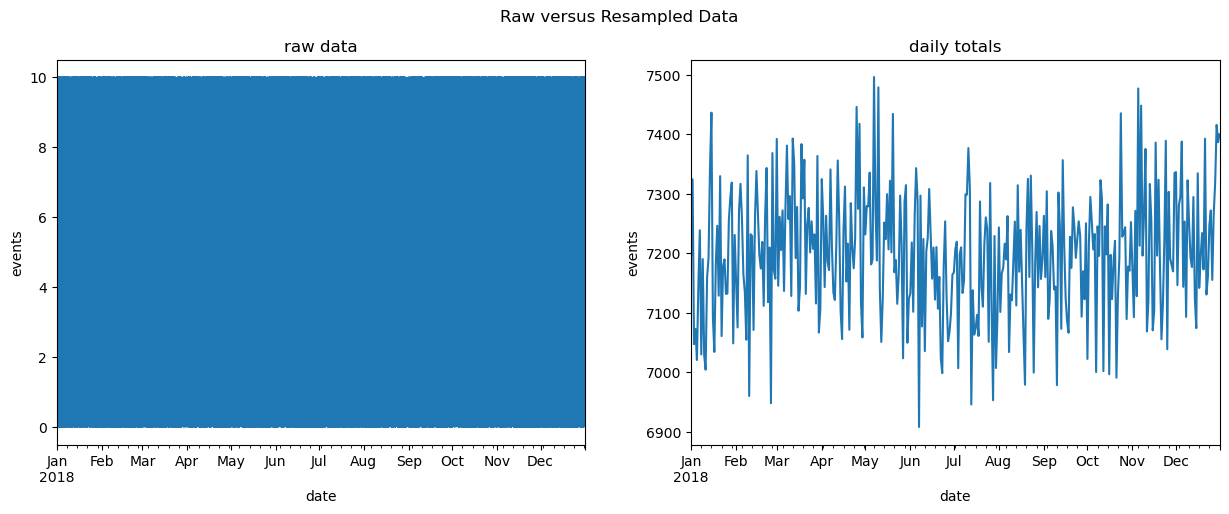

In [199]:
np.random.seed(0)
index = pd.date_range('2018-01-01', freq='T', periods=365*24*60)
raw = pd.DataFrame(
    np.random.uniform(0, 10, size=index.shape[0]), index=index
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
raw.plot(legend=False, ax=axes[0], title='raw data')
raw.resample('1D').sum().plot(legend=False, ax=axes[1], title='daily totals')
for ax in axes:
    ax.set_xlabel('date')
    ax.set_ylabel('events')

plt.suptitle('Raw versus Resampled Data')
plt.show()

In [201]:
stock_data_per_minute.head()

,open,high,low,close,volume
date,,,,,
2019-05-20 09:30:00,181.62,181.62,181.62,181.62,159049.00
2019-05-20 09:31:00,182.61,182.61,182.61,182.61,468017.00
2019-05-20 09:32:00,182.75,182.75,182.75,182.75,97258.00
2019-05-20 09:33:00,182.95,182.95,182.95,182.95,43961.00
2019-05-20 09:34:00,183.06,183.06,183.06,183.06,79562.00


In [203]:
stock_data_per_minute.resample('1D').agg({
 'open': 'first',
 'high': 'max',
 'low': 'min',
 'close': 'last',
 'volume': 'sum'
})

,open,high,low,close,volume
date,,,,,
2019-05-20,181.62,184.18,181.62,182.72,10044838.00
2019-05-21,184.53,185.58,183.97,184.82,7198405.00
2019-05-22,184.81,186.56,184.01,185.32,8412433.00
2019-05-23,182.50,183.73,179.76,180.87,12479171.00
2019-05-24,182.33,183.52,181.04,181.06,7686030.00


In [205]:
fb.resample('Q').mean()

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\46532002.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fb.resample('Q').mean()


TypeError: category dtype does not support aggregation 'mean'

In [207]:
fb.drop(columns='trading_volume').resample('Q').apply(
 lambda x: x.last('1D').values - x.first('1D').values
)

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2934583360.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  fb.drop(columns='trading_volume').resample('Q').apply(
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2934583360.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2934583360.py:2: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2934583360.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  lambda x: x.last('1D').values - x.first('1D').values
C:\Users\uSerr\AppData\Loc

date
2018-03-31    [[-22.53, -20.160000000000025, -23.41000000000...
2018-06-30    [[39.50999999999999, 38.399700000000024, 39.84...
2018-09-30    [[-25.039999999999992, -28.659999999999997, -2...
2018-12-31    [[-28.580000000000013, -31.24000000000001, -31...
Freq: QE-DEC, dtype: object

In [213]:
melted_stock_data = pd.read_csv('datasets/melted_stock_data.csv', index_col='date', parse_dates=True)
melted_stock_data.head()

,price
date,
2019-05-20 09:30:00,181.62
2019-05-20 09:31:00,182.61
2019-05-20 09:32:00,182.75
2019-05-20 09:33:00,182.95
2019-05-20 09:34:00,183.06


In [215]:
melted_stock_data.resample('1D').ohlc()['price']

,open,high,low,close
date,,,,
2019-05-20,181.62,184.18,181.62,182.72
2019-05-21,184.53,185.58,183.97,184.82
2019-05-22,184.81,186.56,184.01,185.32
2019-05-23,182.50,183.73,179.76,180.87
2019-05-24,182.33,183.52,181.04,181.06


In [217]:
fb.resample('6H').asfreq().head()

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2962105639.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').asfreq().head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


In [219]:
fb.resample('6H').pad().head()

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2588024413.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').pad().head()


AttributeError: 'DatetimeIndexResampler' object has no attribute 'pad'

In [221]:
fb.resample('6H').fillna('nearest').head()

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\3498320007.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').fillna('nearest').head()
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\3498320007.py:1: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  fb.resample('6H').fillna('nearest').head()


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 06:00:00,177.68,181.58,177.55,181.42,18151903,low
2018-01-02 12:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-02 18:00:00,181.88,184.78,181.33,184.67,16886563,low
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563,low


In [223]:
fb.resample('6H').asfreq().assign(
 volume=lambda x: x.volume.fillna(0), # put 0 when market is closed
 close=lambda x: x.close.fillna(method='ffill'), # carry forward
 # take the closing price if these aren't available
 open=lambda x: np.where(x.open.isnull(), x.close, x.open),
 high=lambda x: np.where(x.high.isnull(), x.close, x.high),
 low=lambda x: np.where(x.low.isnull(), x.close, x.low)
).head()

C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2081602865.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fb.resample('6H').asfreq().assign(
C:\Users\uSerr\AppData\Local\Temp\ipykernel_14880\2081602865.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close=lambda x: x.close.fillna(method='ffill'), # carry forward


,open,high,low,close,volume,trading_volume
date,,,,,,
2018-01-02 00:00:00,177.68,181.58,177.55,181.42,18151903.00,low
2018-01-02 06:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 12:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-02 18:00:00,181.42,181.42,181.42,181.42,0.00,NaN
2018-01-03 00:00:00,181.88,184.78,181.33,184.67,16886563.00,low


### Merging

In [1]:
import pandas as pd
import sqlite3
with sqlite3.connect('databases/stocks.db') as connection:
 fb_prices = pd.read_sql(
 'SELECT * FROM fb_prices', connection,
 index_col='date', parse_dates=['date']
 )
 aapl_prices = pd.read_sql(
 'SELECT * FROM aapl_prices', connection,
 index_col='date', parse_dates=['date']
 )

In [3]:
fb_prices.index.second.unique()

Index([0], dtype='int32', name='date')

In [5]:
aapl_prices.index.second.unique()

Index([ 0, 52, 36, 34, 55, 35,  7, 12, 59, 17,  5, 20, 26, 23, 54, 49, 19, 53,
       11, 22, 13, 21, 10, 46, 42, 38, 33, 18, 16,  9, 56, 39,  2, 50, 31, 58,
       48, 24, 29,  6, 47, 51, 40,  3, 15, 14, 25,  4, 43,  8, 32, 27, 30, 45,
        1, 44, 57, 41, 37, 28],
      dtype='int32', name='date')

In [7]:
pd.merge_asof(
 fb_prices, aapl_prices,
 left_index=True, right_index=True, # datetimes are in the index
 # merge with nearest minute
 direction='nearest', tolerance=pd.Timedelta(30, unit='s')
).head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.6200,183.5200
2019-05-20 09:31:00,182.6100,NaN
2019-05-20 09:32:00,182.7458,182.8710
2019-05-20 09:33:00,182.9500,182.5000
2019-05-20 09:34:00,183.0600,182.1067


In [10]:
pd.merge_ordered(
 fb_prices.reset_index(), aapl_prices.reset_index()
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.6200,183.520
2019-05-20 09:31:00,182.6100,NaN
2019-05-20 09:31:52,NaN,182.871
2019-05-20 09:32:00,182.7458,NaN
2019-05-20 09:32:36,NaN,182.500


In [14]:
pd.merge_ordered(
 fb_prices.reset_index(), aapl_prices.reset_index(),
 fill_method='ffill'
).set_index('date').head()

,FB,AAPL
date,,
2019-05-20 09:30:00,181.6200,183.520
2019-05-20 09:31:00,182.6100,183.520
2019-05-20 09:31:52,182.6100,182.871
2019-05-20 09:32:00,182.7458,182.871
2019-05-20 09:32:36,182.7458,182.500
